**Machine Learning for Time Series (Master MVA)**

- TP6, Friday 12<sup>th</sup> March 2021
- [Link to the class material.](http://www.laurentoudre.fr/ast.html)

# Introduction

In this notebook, we illustrate the following concept:
- graph signal processing.

## Setup

**Import**

In [1]:
import re
from math import asin, cos, radians, sin, sqrt

import contextily as cx
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from loadmydata.load_molene_meteo import load_molene_meteo_dataset
from matplotlib.dates import DateFormatter
from pygsp import graphs
from scipy.linalg import eigh
from scipy.spatial.distance import pdist, squareform

In [2]:
CRS = "EPSG:4326"

STATION_LIST = [
    "ARZAL",
    "AURAY",
    "BELLE ILE-LE TALUT",
    "BIGNAN",
    "BREST-GUIPAVAS",
    "BRIGNOGAN",
    "DINARD",
    "GUERANDE",
    "ILE DE GROIX",
    "ILE-DE-BREHAT",
    "KERPERT",
    "LANDIVISIAU",
    "LANNAERO",
    "LANVEOC",
    "LORIENT-LANN BIHOUE",
    "LOUARGAT",
    "MERDRIGNAC",
    "NOIRMOUTIER EN",
    "OUESSANT-STIFF",
    "PLEUCADEUC",
    "PLEYBER-CHRIST SA",
    "PLOERMEL",
    "PLOUDALMEZEAU",
    "PLOUGUENAST",
    "PLOUMANAC'H",
    "POMMERIT-JAUDY",
    "PONTIVY",
    "PTE DE CHEMOULIN",
    "PTE DE PENMARCH",
    "PTE DU RAZ",
    "QUIMPER",
    "QUINTENIC",
    "ROSTRENEN",
    "SAINT-CAST-LE-G",
    "SARZEAU SA",
    "SIBIRIL S A",
    "SIZUN",
    "SPEZET",
    "ST BRIEUC",
    "ST NAZAIRE-MONTOIR",
    "ST-SEGAL S A",
    "THEIX",
    "VANNES-SENE",
]

**Utility functions**

In [3]:
def fig_ax(figsize=(15, 3)):
    return plt.subplots(figsize=figsize)

In [4]:
def get_line_graph(n_nodes=10) -> graphs.Graph:
    """Return a line graph."""
    adjacency_matrix = np.eye(n_nodes)
    adjacency_matrix = np.c_[adjacency_matrix[:, -1], adjacency_matrix[:, :-1]]
    adjacency_matrix += adjacency_matrix.T
    line_graph = graphs.Graph(adjacency_matrix)
    line_graph.set_coordinates(kind="ring2D")
    line_graph.compute_laplacian("combinatorial")
    return line_graph

In [5]:
def get_grid_graph(n_nodes_height=10, n_nodes_width=10) -> graphs.Graph:
    """Return a 2D grid graph."""
    g = graphs.Grid2d(n_nodes_height, n_nodes_width)
    xx, yy = np.meshgrid(np.arange(n_nodes_height), np.arange(n_nodes_width))
    coords = np.array((xx.ravel(), yy.ravel())).T
    g.set_coordinates(coords)
    g.compute_laplacian("combinatorial")
    return g

In [6]:
def get_geodesic_distance(point_1, point_2) -> float:
    """
    Calculate the great circle distance (in km) between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/a/4913653
    """

    lon1, lat1 = point_1
    lon2, lat2 = point_2

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [7]:
def get_exponential_similarity(
    condensed_distance_matrix, bandwidth, threshold
):
    exp_similarity = np.exp(
        -(condensed_distance_matrix ** 2) / bandwidth / bandwidth
    )
    res_arr = np.where(exp_similarity > threshold, exp_similarity, 0.0)
    return res_arr

# Graph signal processing

A graph $G$ is a set of $N$ **nodes** connected with **edges**. A **graph signal** is a $\mathbb{R}^N$ vector that is supported by the nodes of the graph $G$.

Graph Signal Processing (GSP) is the set of methods of methods to study such objects.

## Toy data

Let us illustrate the basic principles of GSP on two toy graphs: the line graph and the 2D grid graph.

/home/raph/miniconda3/envs/ast/lib/python3.8/site-packages/pygsp/plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)


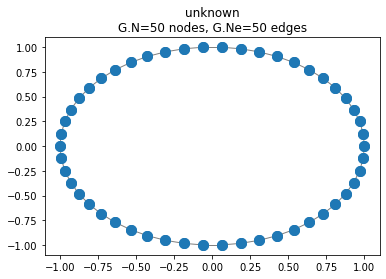

In [8]:
line_graph = get_line_graph(50)  # 50 nodes
line_graph.plot()

/home/raph/miniconda3/envs/ast/lib/python3.8/site-packages/pygsp/plotting.py:94: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show(warn=False)


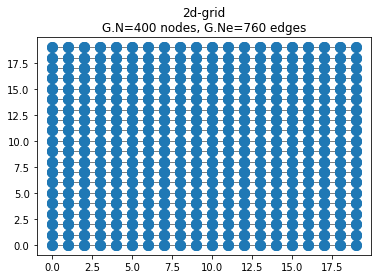

In [9]:
grid_graph = get_grid_graph(20, 20)  # 20 by 20 grid
grid_graph.plot()

We can now generate noisy signals on those two graphs.

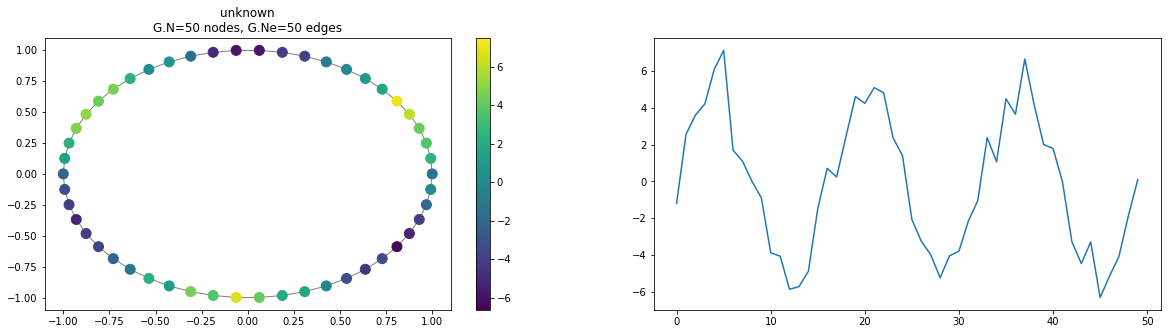

In [10]:
fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
# generate a noisy sinusoid
tt = np.linspace(0, 6 * np.pi, line_graph.N)
signal_line = 5 * np.sin(tt) + np.random.normal(size=line_graph.N)
# plot
line_graph.plot_signal(signal_line, ax=ax_0)
ax_1.plot(signal_line)

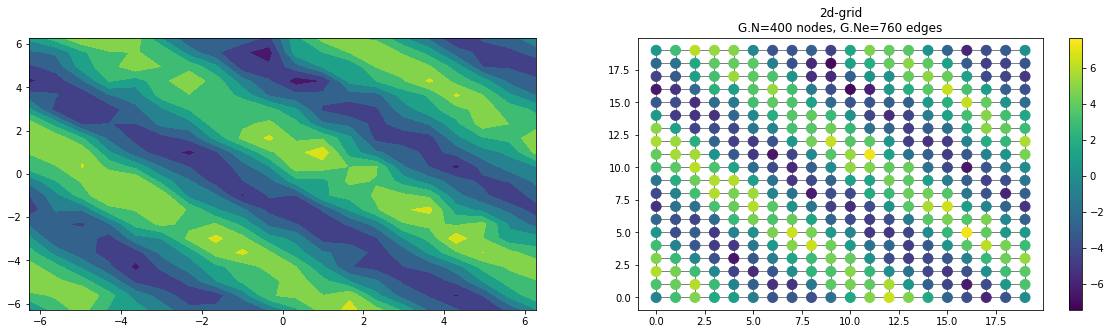

In [11]:
fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# generate a noisy sinusoid
x = np.linspace(-2 * np.pi, 2 * np.pi, 20)
y = np.linspace(-2 * np.pi, 2 * np.pi, 20)
xx, yy = np.meshgrid(x, y, sparse=True)
z = 5 * np.sin(xx + yy)
z += np.random.normal(size=z.shape)
signal_grid = z.flatten()
# plot
ax_0.contourf(x, y, z)
grid_graph.plot_signal(signal_grid, ax=ax_1)

## Fourier basis

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Recall the definition of the Laplacian matrix.</p>
</div>

L = D - A (with D the diagonal matrix of the degrees and A the adjacency matrix)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Compute the Laplacian matrix for both the line graph and the grid graph.</p>
    <p>Verify your result with the Laplacian matrix provided by the <tt>Graph</tt> class (available in <tt>g.L.todense()</tt> for a graph <tt>g</tt>).</p>
</div>

In [12]:
# Line graph
A_line = line_graph.W.todense()
D_line = np.sum(A_line, axis=1).A.squeeze()

L_line = np.diag(D_line) - A_line

# Grid graph
A_grid = grid_graph.W.todense()
D_grid = np.sum(A_grid, axis=1).A.squeeze()

L_grid = np.diag(D_grid) - A_grid

In [13]:
np.allclose(L_line, line_graph.L.todense()), np.allclose(L_grid, grid_graph.L.todense())

(True, True)

In the GSP setting, the Fourier transform derives from the Laplacian $L$ eigendecomposition:

$$
L = U D U^T
$$

where $U$ contains (orthonormal) eigenvectors $u_i$ and $D$ is a diagonal matrix containing the eigenvalues.

For a graph signal $f$, the associated Fourier transform $\hat{f}$ is given by:

$$
\hat{f}:=U^T f.
$$

To illustre this definition, we can compute the Fourier basis on the two graph examples.

On the line graph, we compute and display the eigenvalues and the first eigenvectors.

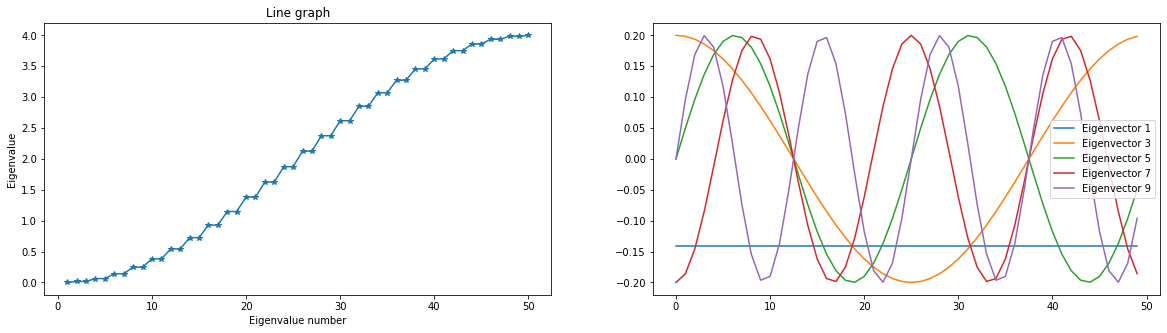

In [14]:
# Laplacian eigendecomposition
eigenvals_line, eigenvects_line = eigh(line_graph.L.todense())

fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax_0.plot(range(1, eigenvals_line.size + 1), eigenvals_line, "-*")
ax_0.set_xlabel("Eigenvalue number")
ax_0.set_ylabel("Eigenvalue")
ax_0.set_title("Line graph")

for k in range(5):
    ax_1.plot(eigenvects_line[:, 2 * k], label=f"Eigenvector {2*k+1}")
_ = plt.legend()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What do you observe on the shape of the eigenvectors?</p>
</div>

It looks like sinusoid signals. And the eigenvectors associated to the smallest eigenvalues have the smallest "frequency".

Second, on the grid graph, we compute and display the eigenvalues and the first and last eigenvectors.

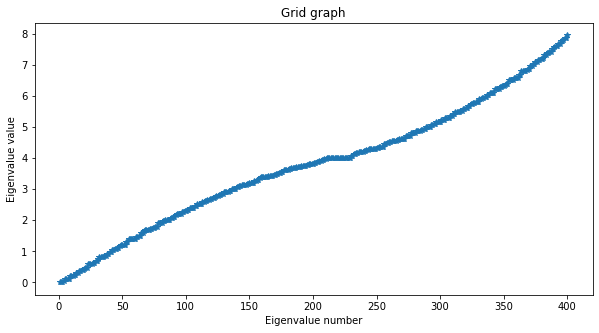

In [15]:
# Laplacian eigendecomposition
eigenvals_grid, eigenvects_grid = eigh(grid_graph.L.todense())

fig, ax_0 = fig_ax(figsize=(10, 5))
ax_0.plot(range(1, eigenvals_grid.size + 1), eigenvals_grid, "-*")
ax_0.set_xlabel("Eigenvalue number")
ax_0.set_ylabel("Eigenvalue value")
_ = ax_0.set_title("Grid graph")

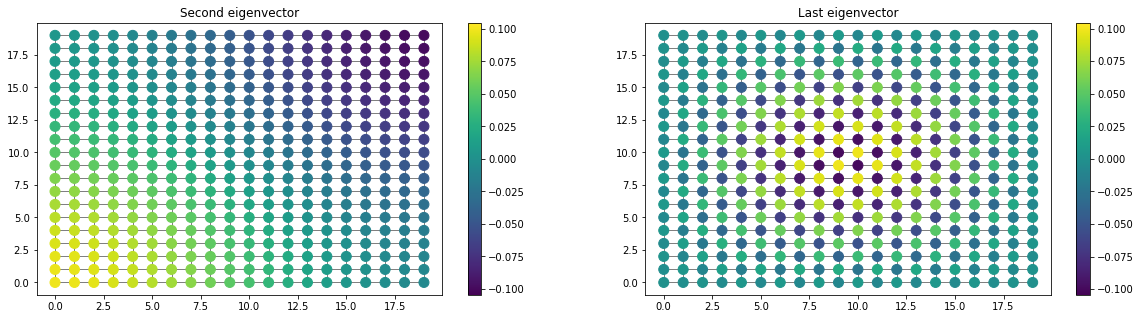

In [16]:
fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

grid_graph.plot_signal(eigenvects_grid[:, 1], ax=ax_0)
ax_0.set_title("Second eigenvector")
grid_graph.plot_signal(eigenvects_grid[:, -1], ax=ax_1)
_ = ax_1.set_title("Last eigenvector")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Visually, which one the two eigenvectors is the smoothest?</p>
    <p>Recall the definition of a graph signal smoothness.</p>
</div>

The smoothest is the second eigenvector. It can be computed with $f^TLf$, which gives in the case of an eigenvector, the associated eigenvalue.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Compute and plot the smoothness of each eigenvector of the Laplacian (of the grid graph).</p>
    <p>What do you observe? Is this expected?</p>
</div>

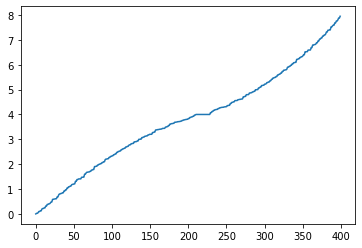

In [17]:
A = (eigenvects_grid.T @ grid_graph.L @ eigenvects_grid)  # Only the diag is needed but easy to do and still fast

plt.plot([A[i, i] for i in range(400)])
plt.show()

We find the eigenvalues. It is totally expected (It's a known result)

## Fourier transform

Using the Fourier basis, we can now compute the Fourier transform of each signal.

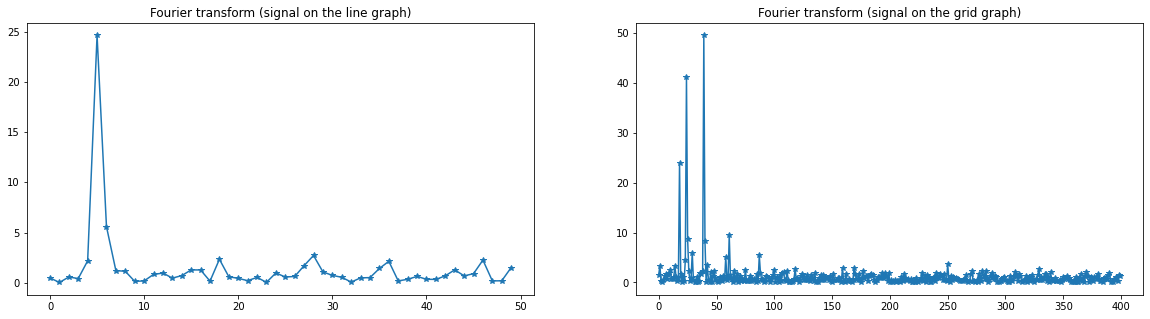

In [18]:
fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# Fourier transform
signal_line_fourier = eigenvects_line.T.dot(signal_line)
signal_grid_fourier = eigenvects_grid.T.dot(signal_grid)


# plot
ax_0.plot(abs(signal_line_fourier), "*-")
ax_0.set_title("Fourier transform (signal on the line graph)")

ax_1.plot(abs(signal_grid_fourier), "*-")
_ = ax_1.set_title("Fourier transform (signal on the grid graph)")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Given the Fourier representation of a signal, how can we recover the original signal?</p>
</div>

We can multiply by U (the eigenvector matrix): $\text{Tf}(f) = U^Tf$ and $f = U\text{Tf}(f)$ (as U is orthonormal)

Since there is a frequency representation, we can filter the signals, as in the classical signal processing setting. For instance, let us set to 0 all Fourier coefficients above a certain cut-off frequency.

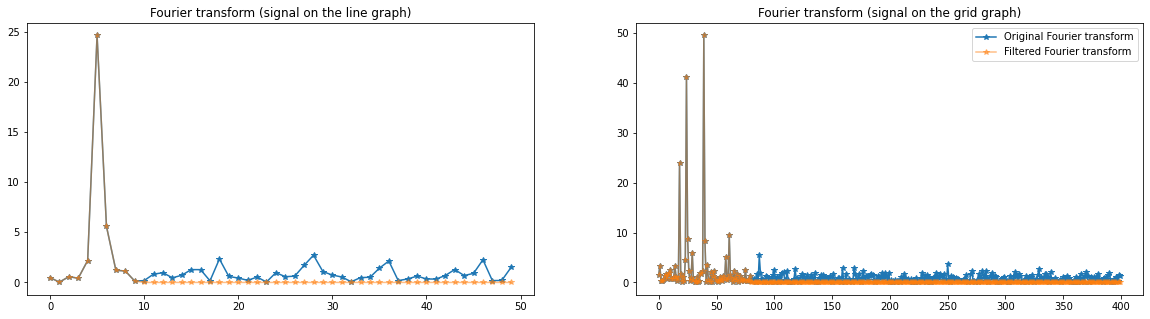

In [19]:
# we keep only 20% of the Fourier coefficients

# filtering the line graph signal
fourier_transform_filtered = np.zeros(signal_line_fourier.size)
fourier_transform_filtered[
    : signal_line_fourier.size // 5
] = signal_line_fourier[: signal_line_fourier.size // 5]
signal_line_filtered = eigenvects_line.dot(fourier_transform_filtered)
# plot
fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax_0.plot(abs(signal_line_fourier), "*-", label="Original Fourier transform")
ax_0.plot(
    abs(fourier_transform_filtered),
    "*-",
    label="Filtered Fourier transform",
    alpha=0.5,
)
ax_0.set_title("Fourier transform (signal on the line graph)")


# filtering the grid graph signal
fourier_transform_filtered = np.zeros(signal_grid_fourier.size)
fourier_transform_filtered[
    : signal_grid_fourier.size // 5
] = signal_grid_fourier[: signal_grid_fourier.size // 5]
signal_grid_filtered = eigenvects_grid.dot(fourier_transform_filtered)
# plot
ax_1.plot(abs(signal_grid_fourier), "*-", label="Original Fourier transform")
ax_1.plot(
    abs(fourier_transform_filtered),
    "*-",
    label="Filtered Fourier transform",
    alpha=0.5,
)
_ = ax_1.set_title("Fourier transform (signal on the grid graph)")

_ = plt.legend()

We then reconstruct the filtered Fourier transform.

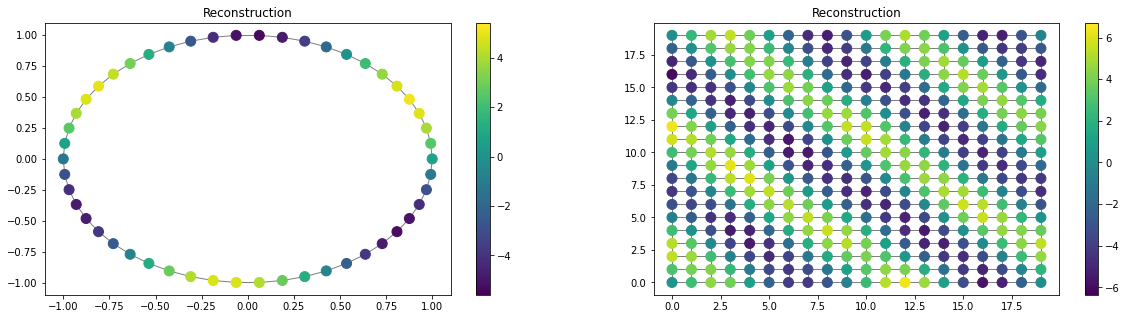

In [20]:
fig, (ax_0, ax_1) = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

line_graph.plot_signal(signal_line_filtered, ax=ax_0)
ax_0.set_title("Reconstruction")
grid_graph.plot_signal(signal_grid_filtered, ax=ax_1)
_ = ax_1.set_title("Reconstruction")

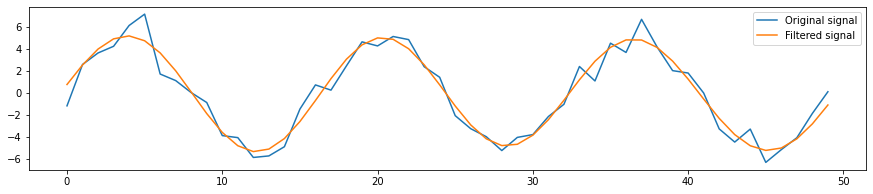

In [21]:
fig, ax = fig_ax()
ax.plot(signal_line, label="Original signal")
ax.plot(signal_line_filtered, label="Filtered signal")
_ = plt.legend()

We can use this procedure to compress signals that are supported on arbitrary graphs.

# Experiments

Let us illustrate a few GSP methods on a real-world data set.

In [22]:
data_df, stations_df, description = load_molene_meteo_dataset()
print(description)

The French national meteorological service made publicly available [1] a data set of hourly observations from a number of weather ground stations. Those stations are located in Brittany, France, and the data were collected during the month of January 2014. The stations recorded several meteorological variables, such as temperature, humidity, wind speed and direction, etc. Missing data (denoted by 'mq' in the original data) are replaced by NaNs.

In addition, the exact positions of the ground stations are provided.

Here is an excerpt of the README file that comes with the data.

    Descriptif  Mnémonique  type    unité
    Paramètres standard
    Indicatif INSEE station numer_sta   car
    Indicatif OMM station   id_omm  int
    Date    date    car
    Point de rosée  td  réel    K
    Température t    réel   K
    Température maximale de l'air   tx  réel    K
    Température minimale de l'air   tn  réel    K
    Humidité    u   int %
    Humidité maximale   ux  int %
    Humidité min

## Data pre-processing

In [23]:
# only keep a subset of stations
keep_cond = stations_df.Nom.isin(STATION_LIST)
stations_df = stations_df[keep_cond]
keep_cond = data_df.station_name.isin(STATION_LIST)
data_df = data_df[keep_cond]

# convert temperature from Kelvin to Celsius
data_df["temp"] = data_df.t - 273.15  # temperature in Celsius

# convert pandas df to geopandas df
stations_gdf = geopandas.GeoDataFrame(
    stations_df,
    geometry=geopandas.points_from_xy(
        stations_df.Longitude, stations_df.Latitude
    ),
).set_crs(CRS)

stations_gdf.head()

,Numéro,Nom,Latitude,Longitude,X (Lambert II étendu),Y (Lambert II étendu),Altitude,geometry
0,22016001,ILE-DE-BREHAT,48.855167,-3.004500,208083,2441852,25,POINT (-3.00450 48.85517)
1,22092001,KERPERT,48.404000,-3.147667,194096,2392507,281,POINT (-3.14767 48.40400)
2,22113006,LANNAERO,48.755333,-3.468667,173267,2433190,85,POINT (-3.46867 48.75533)
3,22135001,LOUARGAT,48.551667,-3.376833,178359,2410097,148,POINT (-3.37683 48.55167)
4,22147006,MERDRIGNAC,48.182667,-2.410833,247067,2364385,131,POINT (-2.41083 48.18267)


In [24]:
data_df.head()

,numer_sta,date,date_insert,td,t,tx,tn,u,ux,un,...,vv,etat_sol,sss,n,insolh,ray_glo01,pres,pmer,station_name,temp
0,29163003,2014-01-01 00:00:00,2014-01-01 00:05:55,278.95,280.85,281.25,280.85,88.0,88.0,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PLEYBER-CHRIST SA,7.7
1,29163003,2014-01-01 01:00:00,2014-01-01 01:05:59,279.25,280.95,280.95,280.65,89.0,90.0,88.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PLEYBER-CHRIST SA,7.8
2,29163003,2014-01-01 02:00:00,2014-01-01 02:06:05,278.95,280.95,281.15,280.85,87.0,90.0,87.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PLEYBER-CHRIST SA,7.8
3,29163003,2014-01-01 03:00:00,2014-01-01 03:06:09,278.75,281.15,281.15,280.95,85.0,87.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PLEYBER-CHRIST SA,8.0
4,29163003,2014-01-01 04:00:00,2014-01-01 04:06:14,278.95,281.65,281.65,281.15,83.0,85.0,83.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PLEYBER-CHRIST SA,8.5


Pivot the table. We now have a multivariate time serie.

In [25]:
temperature_df = data_df.pivot(
    index="date", values="temp", columns="station_name"
)
temperature_df.head()

station_name,ARZAL,AURAY,BELLE ILE-LE TALUT,BIGNAN,BREST-GUIPAVAS,BRIGNOGAN,DINARD,GUERANDE,ILE DE GROIX,ILE-DE-BREHAT,...,SAINT-CAST-LE-G,SARZEAU SA,SIBIRIL S A,SIZUN,SPEZET,ST BRIEUC,ST NAZAIRE-MONTOIR,ST-SEGAL S A,THEIX,VANNES-SENE
date,,,,,,,,,,,,,,,,,,,,,
2014-01-01 00:00:00,9.7,10.3,11.3,7.1,9.7,NaN,6.8,10.4,9.0,7.0,...,6.1,9.8,7.4,8.5,8.3,7.5,9.0,9.0,9.3,9.7
2014-01-01 01:00:00,9.8,10.4,10.3,7.6,9.6,9.2,6.5,10.6,10.0,7.0,...,6.3,9.9,8.2,8.3,8.6,7.0,9.1,9.5,9.1,9.9
2014-01-01 02:00:00,9.7,10.0,11.2,7.7,9.1,9.4,6.5,10.2,9.5,7.8,...,6.4,9.2,8.5,8.5,8.6,7.5,9.5,9.4,9.4,9.6
2014-01-01 03:00:00,9.4,10.4,11.4,7.9,9.7,10.1,7.1,10.6,10.4,8.3,...,7.0,10.1,8.5,8.7,8.9,7.2,9.0,9.9,8.9,9.8
2014-01-01 04:00:00,9.8,10.8,11.4,8.8,9.8,10.2,7.6,10.6,10.8,8.9,...,7.7,10.5,9.1,9.1,9.4,7.6,9.5,10.0,9.6,10.2


Plot the position of the grounds stations on a map.

In [ ]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()

## Data exploration

We can start by checking for some malfunctions in the stations. To that end, we simply count the number of NaNs.

In [28]:
temperature_df.isna().sum(axis=0).sort_values(ascending=False).head()

station_name
ST NAZAIRE-MONTOIR    70
LANNAERO              37
PLOUDALMEZEAU          2
SIZUN                  1
QUIMPER                1
dtype: int64

After this, we can look at the (geodesic) distance between stations.

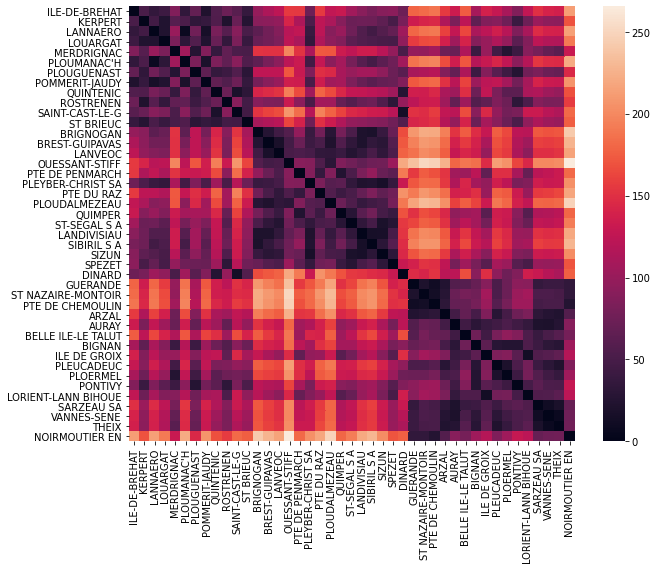

In [29]:
stations_np = stations_df[["Longitude", "Latitude"]].to_numpy()
dist_mat_condensed = pdist(stations_np, metric=get_geodesic_distance)
dist_mat_square = squareform(dist_mat_condensed)

fig, ax = fig_ax((10, 8))
_ = sns.heatmap(
    dist_mat_square,
    xticklabels=stations_df.Nom,
    yticklabels=stations_df.Nom,
    ax=ax,
)

For instance, we can find the two closest stations.

In [30]:
# find the minimum distance. We need to fill the diagonal, because it is zero.
argmin_index = np.argmin(
    dist_mat_square + np.eye(dist_mat_square.shape[0]) * 1e6
)
# argmin_index is the argmin index in the flattened (1D) version of the matrix.
# We need it in the 2D array
argmin_index = np.unravel_index(argmin_index, dist_mat_square.shape)
station_1_index, station_2_index = argmin_index
# get names of stations
station_1, station_2 = stations_df.iloc[
    [station_1_index, station_2_index]
].Nom.to_numpy()
# print result
msg = f"The two closest stations are {station_1} and {station_2} ({dist_mat_square[station_1_index, station_2_index]:.1f} km)."
print(msg)

The two closest stations are LANNAERO and PLOUMANAC'H (7.8 km).


<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What are the two most distant stations?</p>
</div>

In [31]:
# find the minimum distance. We need to fill the diagonal, because it is zero.
argmax_index = np.argmax(
    dist_mat_square * 1e6
)
# argmin_index is the argmin index in the flattened (1D) version of the matrix.
# We need it in the 2D array
argmax_index = np.unravel_index(argmax_index, dist_mat_square.shape)
station_1_index, station_2_index = argmax_index
# get names of stations
station_1, station_2 = stations_df.iloc[
    [station_1_index, station_2_index]
].Nom.to_numpy()
# print result
msg = f"The two most distant stations are {station_1} and {station_2} ({dist_mat_square[station_1_index, station_2_index]:.1f} km)."
print(msg)

The two most distant stations are OUESSANT-STIFF and NOIRMOUTIER EN (265.5 km).


We can plot the temperature evolution for the two closest stations.

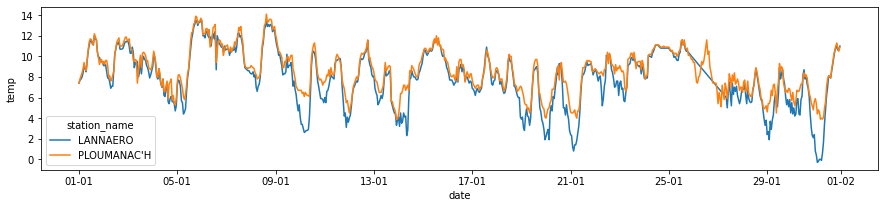

In [32]:
fig, ax = fig_ax()

keep_cond = data_df.station_name.isin(["LANNAERO", "PLOUMANAC'H"])
sns.lineplot(
    data=data_df[keep_cond], x="date", y="temp", hue="station_name", ax=ax
)

myFmt = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(myFmt)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Do the same for the two most distant stations.</p>
</div>

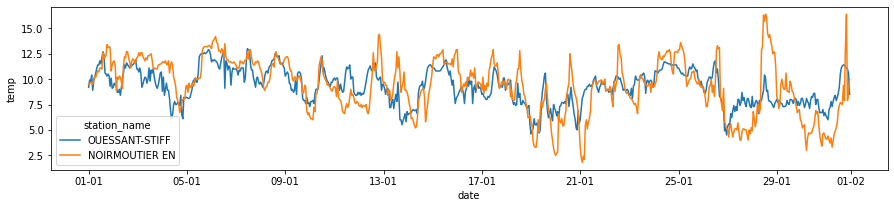

In [33]:
fig, ax = fig_ax()

keep_cond = data_df.station_name.isin(["OUESSANT-STIFF", "NOIRMOUTIER EN"])
sns.lineplot(
    data=data_df[keep_cond], x="date", y="temp", hue="station_name", ax=ax
)

myFmt = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(myFmt)

## Graph construction

This network of sensors can be modeled as a graph, and the temperature signal, as a serie of graph signals.

To that end, we need to define a graph.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Give two ways to derive an adjacency matrix from a distance matrix?</p>
</div>

We can use knn graphs or epsilon graphs to filter edges, and use a gaussian kernel.

### Distance-based weigthless graph

In [34]:
threshold = 35  # km
adjacency_matrix = squareform((dist_mat_condensed < threshold).astype(int))
G = graphs.Graph(adjacency_matrix)
print(
    f"The graph is {'not ' if not G.is_connected() else ''}connected, with {G.N} nodes, {G.Ne} edges"
)

The graph is not connected, with 43 nodes, 78 edges


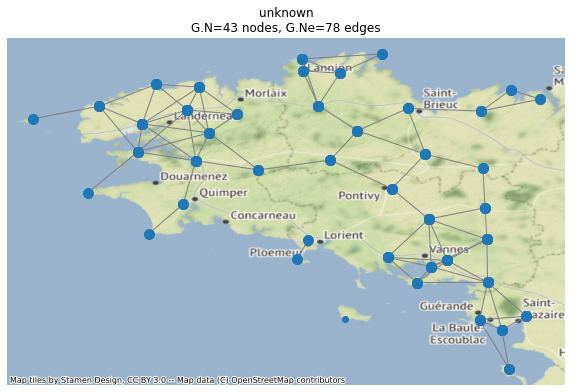

In [35]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G.set_coordinates(stations_np)
G.plot(ax=ax)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Plot the number of edges with respect to the threshold.</p>
    <p>What is approximatively the lowest threshold possible in order to have a connected graph?</p>
</div>

In [44]:
thresholds = list(range(100))
connected = []
edges = []

for threshold in thresholds:
    adjacency_matrix = squareform((dist_mat_condensed < threshold).astype(int))
    G = graphs.Graph(adjacency_matrix)
    connected.append(G.is_connected())
    edges.append(G.Ne)
    
i = connected.index(True)
print(i)

40


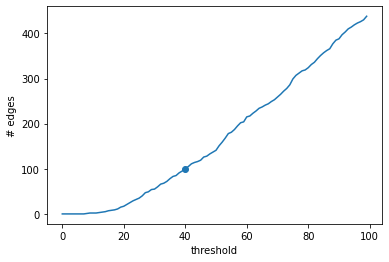

In [45]:
plt.plot(thresholds, edges)
plt.ylabel("# edges")
plt.xlabel("threshold")
plt.scatter([thresholds[i]], [edges[i]])
plt.show()

We should have at least 40km of threshold to keep the graph connected

### Distance-based weighted graph

Each vertex can be connected to other vertices by edges weighted by a Gaussian kernel:
$$
W_{ij} = \exp\left(-\frac{\|c_i-c_j\|^2}{\sigma^2}\right) \quad\text{if}\quad \exp\left(-\frac{\|c_i-c_j\|^2}{\sigma^2}\right)>\lambda,\ 0\ \text{otherwise}
$$
where the $c_i$ are the station positions, $\sigma$ is the so-called bandwidth parameter, and $\lambda>0$ is a threshold. 

In [48]:
sigma = np.median(dist_mat_condensed)  # median heuristic
threshold = 0.85
adjacency_matrix_gaussian = squareform(
    get_exponential_similarity(dist_mat_condensed, sigma, threshold)
)
G_gaussian = graphs.Graph(adjacency_matrix_gaussian)
print(
    f"The graph is {'not ' if not G_gaussian.is_connected(recompute=True) else ''}connected, with {G_gaussian.N} nodes, {G_gaussian.Ne} edges"
)

The graph is connected, with 43 nodes, 105 edges


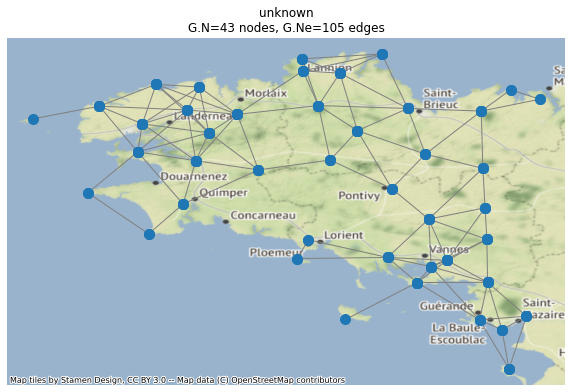

In [49]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot(ax=ax)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> What is the influence of the threshold.</p>
    <p>Choose an appropriate value for the threshold.</p>
</div>

In [46]:
thresholds = np.linspace(0, 1, 101)
connected = []
edges = []

for threshold in thresholds:
    adjacency_matrix = squareform(
        get_exponential_similarity(dist_mat_condensed, sigma, threshold)
    )
    G = graphs.Graph(adjacency_matrix)
    connected.append(G.is_connected())
    edges.append(G.Ne)
    
i = connected.index(False) - 1

print(i)

85


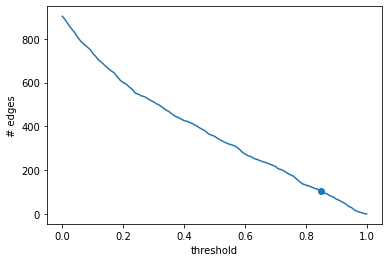

In [47]:
plt.plot(thresholds, edges)
plt.ylabel("# edges")
plt.xlabel("threshold")
plt.scatter([thresholds[i]], [edges[i]])
plt.show()

High threshold induces few edges. 0.85 is a good choice to have a connected graph.

### Correlation graph

The correlation between the signals can also define a graph.

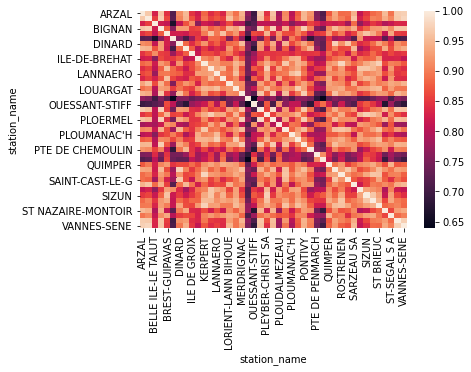

In [50]:
_ = sns.heatmap(temperature_df.corr())

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p> Describe how to create a graph using the signal correlation.</p>
</div>

We can also use a threshold. (Or also knn)

In [51]:
correlation_matrix = temperature_df.corr().to_numpy()

correlation_threshold = 0.95
adjacency_matrix_corr = np.where(
    correlation_matrix > correlation_threshold, correlation_matrix, 0.0
)
np.fill_diagonal(a=adjacency_matrix_corr, val=0.0)
G_corr = graphs.Graph(adjacency_matrix_corr)
print(
    f"The graph is {'not ' if not G_corr.is_connected(recompute=True) else ''}connected, with {G_corr.N} nodes, {G_corr.Ne} edges"
)

The graph is not connected, with 43 nodes, 78 edges


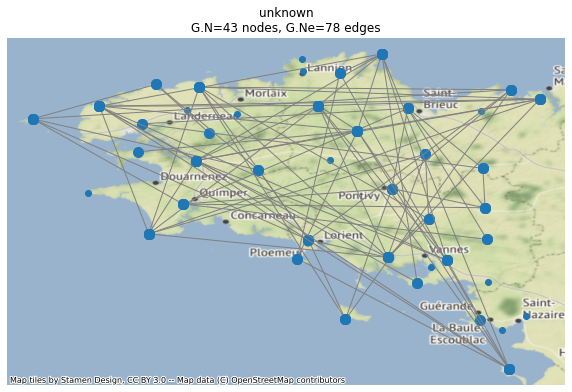

In [52]:
ax = stations_gdf.geometry.plot(figsize=(10, 10))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_corr.set_coordinates(stations_np)
G_corr.plot(ax=ax)

Note that stations that are very far apart can be connected. This unveils a different structure.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Find the number of connected components using the Laplacian matrix. (Recall that the number of zero eigenvalues is equal to the number of connected components.)</p>
</div>

In [53]:
eigenvalues = np.linalg.eigh(G_corr.L.todense())[0]
np.sum(eigenvalues < 1e-8)

12

## Graph signal processing

In this section, we set the graph to the one that comes from the Gaussian kernel.

### Signal smoothness

Let us study the signal smoothness, at each hour of measure.

In [54]:
# drop the NaNs
temperature_df_no_nan = temperature_df.dropna(axis=0, how="any")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Compute the smoothness for a specific hour of measure.</p>
</div>

In [55]:
# choose a specific hour
choosen_hour = pd.to_datetime("2014-01-01 01:00:00")
L = G_gaussian.L.todense()
signal = temperature_df_no_nan.loc[choosen_hour]

smooth = signal.T @ L @ signal
print(f"Smoothness: {smooth:.2f}")

Smoothness: 350.39


We can display the smoothess evolution with time.

In [56]:
signals = temperature_df_no_nan.to_numpy()
smoothness_arr = np.array(
    [float(signal.T.dot(L).dot(signal)) for signal in signals]
)
smoothness_df = pd.Series(
    data=smoothness_arr, index=temperature_df_no_nan.index
)

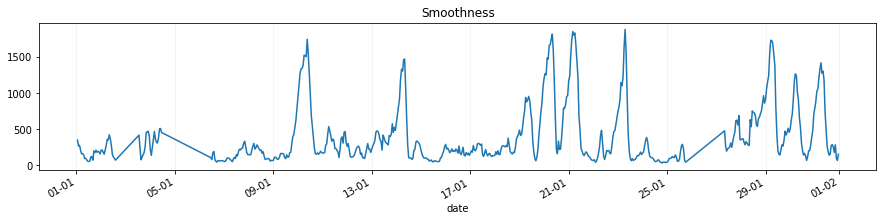

In [57]:
fig, ax = fig_ax()
smoothness_df.plot(ax=ax)
myFmt = DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(myFmt)
ax.set_title("Smoothness")
plt.grid(axis="x", color="0.95")

This displays interesting patterns. We can show the state of the network, when the signal is the smoothest.

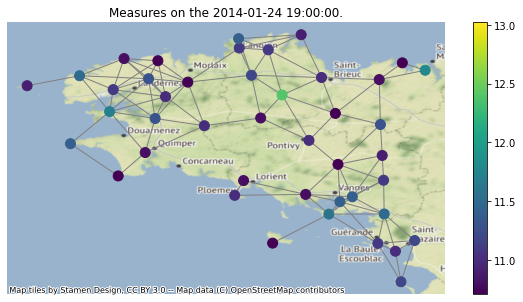

In [58]:
argmin_index = smoothness_df.argmin()
signal = temperature_df_no_nan.iloc[argmin_index].to_numpy()
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(signal, ax=ax)
_ = ax.set_title(
    f"Measures on the {temperature_df_no_nan.index[argmin_index]}."
)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Do the same, when the signal is the least smooth.</p>
</div>

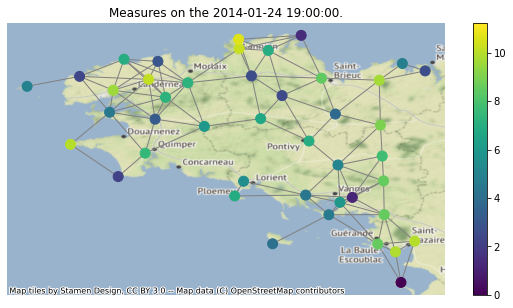

In [59]:
argmax_index = smoothness_df.argmax()
signal = temperature_df_no_nan.iloc[argmax_index].to_numpy()
ax = stations_gdf.geometry.plot(figsize=(10, 5))
cx.add_basemap(ax, crs=stations_gdf.crs.to_string(), zoom=8)
ax.set_axis_off()
G_gaussian.set_coordinates(stations_np)
G_gaussian.plot_signal(signal, ax=ax)
_ = ax.set_title(
    f"Measures on the {temperature_df_no_nan.index[argmin_index]}."
)